In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression

# model functionality and validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# regressor models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [20]:
# data pipeline

# read in file
raw_data = pd.read_csv("AmesHousing.csv", "~")

# see what has been loaded
raw_data.keys()

# select most likely key features
data = raw_data[["SalePrice", "1st Flr SF", "2nd Flr SF", "MS Zoning", "MS SubClass", "Lot Frontage", "Lot Area", 
                 "Land Contour", "Bldg Type", "House Style", "Overall Qual", "Overall Cond", "Year Built", 
                 "Year Remod/Add", "Bsmt Qual", "Bsmt Cond", "Heating", "Central Air", "Full Bath", 
                 "Half Bath", "Bedroom AbvGr", "Fireplaces", "Garage Type", "Garage Cars", "Pool Area", 
                 "Pool QC", "Yr Sold"]]

# ensure we've loaded what we want
data.keys()

# convert to a simplified dataframe for initial work
simple_data = data[["SalePrice", "1st Flr SF", "2nd Flr SF", "Year Built", "Full Bath", "Half Bath", 
                    "Bedroom AbvGr", "Garage Cars", "Yr Sold", "Overall Qual", "Lot Area", "Lot Frontage",
                   "Pool Area", "Fireplaces", "MS SubClass"]]
##############################################################################
# Years Since Update                                                 #########
##############################################################################

simple_data.loc[:,"yrs_since_update"] = 2010 - data["Year Remod/Add"] + np.random.normal(-0.001, .001, size=1)

##############################################################################
# Overall Cond                                                       #########
##############################################################################

temp = data["Overall Cond"]
print temp.unique()
# [5 6 7 2 8 4 9 3 1]
oc_dum = pd.get_dummies(temp)
key_list = temp.unique()
new_key_list = ["oc_" + str(key) for key in key_list]
oc_dum.columns = [new_key_list]
print oc_dum.head()
simple_data = pd.concat((simple_data, oc_dum), axis=1)
# simple_data.pop("Overall Cond")

##############################################################################
# MS SubClass                                                        #########
##############################################################################

# print simple_data["MS SubClass"].unique()
# [ 20  60 120  50  85 160  80  30  90 190  45  70  75  40 180 150]
ms_sub = pd.get_dummies(simple_data["MS SubClass"])

key_list = simple_data["MS SubClass"].unique()

new_key_list = ["ms_sub_" + str(key) for key in key_list]
ms_sub.columns = [new_key_list]
# print ms_sub
simple_data = pd.concat((simple_data, ms_sub), axis=1)
simple_data.pop("MS SubClass")


##############################################################################
# basement stuff                                                     #########
##############################################################################

# print data["Bsmt Qual"].unique()

boink = pd.get_dummies(data["Bsmt Qual"])
# [u'Ex', u'Fa', u'Gd', u'Po', u'TA']
boink.columns = ["bsmt_qual_ex", "bsmt_qual_fa", "bsmt_qual_gd", "bsmt_qual_po", "bsmt_qual_ta" ]

simple_data = pd.concat((simple_data, boink), axis=1)

##############################################################################
# pool data                                                          #########
##############################################################################

# has_pool = np.array(simple_data.loc[:,"Pool Area"] > 0)
# has_pool_df = pd.DataFrame(has_pool, columns=["has_pool"])
# simple_data = pd.concat((simple_data, has_pool_df), axis=1)


##############################################################################
# use the oneHot encoder to create dummy columns for overall quality #########
##############################################################################
encoder = OneHotEncoder()
temp = simple_data["Overall Qual"]
overall_qual_dummies = encoder.fit_transform(temp.values.reshape(-1, 1))
overall_qual_dummies = overall_qual_dummies.toarray()
print "overall_qual_dummies shape:", overall_qual_dummies.shape

oq_dummies = pd.DataFrame(overall_qual_dummies, columns=["oq_1", "oq_2", "oq_3", "oq_4", "oq_5", "oq_6", 
                                                         "oq_7", "oq_8", "oq_9", "oq_10"])
# print oq_dummies.head()

simple_data = pd.concat((simple_data, oq_dummies), axis=1)
simple_data.pop("Overall Qual")


# Fuzzing Quality seemed to hurt accuracy, perhaps because there wasn't a super dominant feature
# print simple_data.keys()
# simple_data.loc["Overall Qual"] = simple_data[simple_data["Overall Qual"] + np.random.uniform(-0.001, 0.001, size=len(simple_data))]
# simple_data.loc[:, "Overall Qual"] += np.random.normal(-0.001, 0.001, size=1)


##############################################################################
# Figure out Square footage information                              #########
##############################################################################
# fill in nan for 2nd floor square feet with zeros, which makes sense
simple_data.loc[:, "2nd Flr SF"].fillna(0, inplace=True)

# calculate simple square footage
square_feet = simple_data.loc[:,"1st Flr SF"] + simple_data.loc[:,"2nd Flr SF"]

# add this to the data frame then clean up the data frame some
simple_data = pd.concat((simple_data, square_feet), axis=1)
simple_data.pop(0)
simple_data.drop("1st Flr SF", axis=1, inplace=True)
simple_data.drop("2nd Flr SF", axis=1, inplace=True)

# fix nans
simple_data["Garage Cars"].fillna(0, inplace=True)

simple_data["Lot Frontage"].fillna(simple_data["Lot Frontage"].mean(), inplace=True)

##############################################################################
# Create "lot_ratio" which is "Lot Area" / "Lot Frontage"            #########
##############################################################################
simple_data.loc[:, "lot_length"] = simple_data.loc[:,"Lot Area"] / (simple_data.loc[:, "Lot Frontage"] * 1.0)

simple_data.loc[:, "lot_ratio"] = simple_data.loc[:,"Lot Frontage"] / (simple_data.loc[:, "lot_length"] * 1.0)
simple_data.pop("lot_length")

##############################################################################
# Bathroom feature manipulation                                      #########
##############################################################################
# combine bathroom stats
# simple_data.loc[:, "total_baths"] = simple_data.loc[:, "Full Bath"] + simple_data.loc[:, "Half Bath"]

# simple_data["total_baths"] = simple_data["total_baths"].mask(simple_data["total_baths"] == 0, 0.1)

# simple_data.loc[:, "bed_to_bath"] = simple_data.loc[:, "Bedroom AbvGr"] / (simple_data.loc[:, "total_baths"] * 1.0)

############################################################################## 
# Pop out pricing labels                                             #########
##############################################################################
Y = simple_data.loc[:,"SalePrice"]

# create log prices version
log_Y = np.log10(Y)

##############################################################################
# Print out basic info for constructed dataframe                     #########
##############################################################################
simple_data.pop("SalePrice")

print simple_data.describe()

print
print simple_data.info()

simple_df = simple_data

############################################################################## 
# Scale/standardize features                                         #########
##############################################################################
scaler = StandardScaler()
simple_data = scaler.fit_transform(simple_data)

##############################################################################
# Track Feature Engineering Evolution                                #########
##############################################################################

# try to fuzz "Overall Qual" so that it can't totally drill in on any particular value
# Starting ensemble with "simple_data" 
# Mean RMSE of 10 Runs:54667.0
#
# Add "Overall Qual" feature
# Mean RMSE of 10 Runs:46235.5
#
# Fuzzed "Overall Qual" Feature
# Mean RMSE of 10 Runs:46102.1
#
# Dummified "Overall Qual" feature
# Mean RMSE of 10 Runs:46572.3
# really helped RandomForests and LinearRegression though
#
# Tuned Gradient Boosting Hyper Parameters with quality dummies disabled
# Mean RMSE of 10 Runs:37670.7
#
# Enabled Dummified overall quality
# Mean RMSE of 10 Runs:38282.8
#
# Modified splitting to keep 20% of original data for use as validation set to prevent
# overall overfitting because the model tuning is being run so many times
# Mean RMSE of 10 Runs:38118.5
#
# Include "Lot Area" feature
# Mean RMSE of 10 Runs:36766.1
#
# Include "Lot Frontage" feature
# Mean RMSE of 10 Runs:34989.0
#
# Create "lot_length" feature "Lot Area" / "Lot Frontage"
# Mean RMSE of 10 Runs:37455.6
#
# Create "lot_ratio" which is "Lot Frontage" / "lot_length"
# Mean RMSE of 10 Runs:35728.2
#
# Create "total_baths"
# Mean RMSE of 10 Runs:36547.2
#
# Tuned DecisionTree max_depth hyper parameter to 7
# Mean RMSE of 10 Runs:34161.9
#
# Fireplaces
# Mean RMSE of 10 Runs:34219.6
#
# bed_to_bath ratio
# Mean RMSE of 10 Runs:33950.7
#
# basement quality dummy columns
# Mean RMSE of 10 Runs:34915.2
#
# removed basement quality dummy columns
# Mean RMSE of 10 Runs:34795.2
#
# Added Ridge model to ensemble, re-enabled pool and basement
# Mean RMSE of 10 Runs:34116.1
#
# Standardize the data
# Mean RMSE of 10 Runs:32079.9
#
# Add log transformation of prices
# Unsure if it helped but seemed to cause a lot of problems, weirdly
#
# Add MS Subclass
# Mean RMSE of 10 Runs:35276.2
#
# Dummify MS Subclass (forgot to pop it so the base column for MS Subclass still present)
# Mean RMSE of 10 Runs:32194.4
#
# Popped MS Subclass base (went up but probably just variance)
# Mean RMSE of 10 Runs:33467.0
#
# Removed decision tree from ensemble since it's fairly similar to random forests
# Mean RMSE of 10 runs: 33179.8
#
# Make dummy columns for 'Overall Condition' and add that to simple_data
# Mean RMSE of 10 Runs:33015.1
#
# Linear regression model still periodically 'exploding' 
# Linear RMSE: 1.15322876772e+16

[5 6 7 2 8 4 9 3 1]
   oc_5  oc_6  oc_7  oc_2  oc_8  oc_4  oc_9  oc_3  oc_1
0     0     0     0     0     1     0     0     0     0
1     0     0     0     0     0     1     0     0     0
2     0     0     0     0     0     1     0     0     0
3     0     0     0     0     1     0     0     0     0
4     0     0     0     0     1     0     0     0     0
overall_qual_dummies shape: (2930, 10)
        Year Built    Full Bath    Half Bath  Bedroom AbvGr  Garage Cars  \
count  2930.000000  2930.000000  2930.000000    2930.000000  2930.000000   
mean   1971.356314     1.566553     0.379522       2.854266     1.766212   
std      30.245361     0.552941     0.502629       0.827731     0.761137   
min    1872.000000     0.000000     0.000000       0.000000     0.000000   
25%    1954.000000     1.000000     0.000000       2.000000     1.000000   
50%    1973.000000     2.000000     0.000000       3.000000     2.000000   
75%    2001.000000     2.000000     1.000000       3.000000     2.000000 

In [21]:
32194 / Y.mean()

0.17806803968983165

## Function Definitions:

In [22]:
def make_data_splits(X, Y):
    '''
    Take data in and split it into 3 sets for a 2 stage stacked ensemble
    return 3 X_set splits and 3 y_set splits like:
    X_train1, X_train2, X_test, y_train1, y_train2, y_test
    '''
    # split the data for train and test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

#     print "y_train", y_train.shape
#     print "X_train", X_train.shape
#     print "y_test", y_test.shape
#     print "X_test", X_test.shape

    # subdivide again for 2 stage ensemble
    X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5)

    y_train1 = y_train1.reshape(-1, 1)
    y_train2 = y_train2.reshape(-1, 1)
    
    return X_train1, X_train2, X_test, y_train1, y_train2, y_test

def run_multi_stack(X, y, log_y=False):
    '''
    Simply take the average prediction of several models and use that for a prediction
    
    Returns the RMSE resulting from that
    '''
    
    # tuned stage 1 gradient boosting with n_estimators 10,000 learning rate 0.001
    # Mean RMSE of 10 Runs:38670.5

    # tuned stage 1 gradient boosting with n_estimators 1,000 learning rate 0.01
    # Mean RMSE of 10 Runs:38626.6

    # tuned stage 2 gradient boosting with n_estimators 1,000 learning rate 0.01
    # Mean RMSE of 10 Runs:37670.7
    
    # tuned DecisionTreeRegressor with max depth from 1 to 100 and ~7 was the minimum
    
    # prevent overfitting on eval type data esp since we're doing a junky for loop for multiple
    # fold testing

    # add in log y transformation
    
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=42, test_size=0.2)
    
    # split the data for train and test
    X_train1, X_train2, X_test, y_train1, y_train2, y_test = make_data_splits(X_train, y_train)
    
    m1 = SVR(C=2.0)
    m2 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    m3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
    m4 = LinearRegression(fit_intercept=True)
    m5 = DecisionTreeRegressor(max_depth=7)
    m6 = Ridge()
    
    models = [m2, m3, m4, m6]

    preds = np.zeros((len(y_train2), len(models)))
    for idx, model in enumerate(models):
        # print "Fitting {}...".format(model.__class__.__name__)
        if log_y == True:
            model.fit(X_train1, np.log10(y_train1).ravel())
        else:
            model.fit(X_train1, y_train1.ravel())
        
        # print "Predicting {}...".format(model.__class__.__name__)
        results = model.predict(X_train2).ravel()
        
        preds[:,idx] = results
        

    # figure out RMSE of the average of the preds
    rmses = []
    for x in range(len(models)):
#         if x == 2:
#             print "max in preds[{:2d}]:{}".format(x, preds[:,x].max())

#             print "model coefs:"
#             for att, coef in zip(simple_df.keys(), models[x].coef_):
#                 print "{:<20}    {:12.0f}".format(att, coef)
        
        if log_y == True:
            rmse = np.sqrt(mean_squared_error(10**preds[:,x], y_train2.ravel()))
        else:
            rmse = np.sqrt(mean_squared_error(preds[:,x], y_train2.ravel()))
            
        rmses.append(rmse)
    
#     print "\n\n"
    print "First stage RMSEs:"
    print "{:<20} {:<20} {:<20} {:<20}".format("Random Forest", "Gradient Boosting", 
                                               "Linear Regression", "Ridge")
    print "{:<20} {:<20} {:<20} {:<20}".format(rmses[0], rmses[1], rmses[2], rmses[3])
#     print "\n\n"
    
    # second stage model that takes predictions from models trained on first whack of data
    blender = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.001)
    
    # fit blender
    if log_y == True:
        blender.fit(preds, np.log10(y_train2))
    else:
        blender.fit(preds, y_train2)
        
    # now take in the whole pipeline on the test set
    
    # first get predictions on test set from the stage 1 models
    final_s1_preds = np.zeros((len(y_test), len(models)))
    
    for idx, model in enumerate(models):
        #print "Predicting Test data with {}...".format(model.__class__.__name__)
        results = model.predict(X_test).ravel()
        
        final_s1_preds[:,idx] = results
    
    final_preds = blender.predict(final_s1_preds)
    
    # convert back to normal, non-log10, prices
    if log_y == True:
        final_preds = 10**final_preds
    # else don't have to do anything
    
    rmse = np.sqrt(mean_squared_error(final_preds, y_test))
    
    print "Final RMSE:{:6.1f}\n".format(rmse)
    
    return rmse

## Run model 10 times to get mean RMSE

In [23]:
num_runs = 10

outcomes = np.zeros((num_runs,1))

for x in range(num_runs):
    outcomes[x] = run_multi_stack(simple_data, Y)
    
print "\nMean RMSE of 10 Runs:{:6.1f}".format(outcomes.mean())

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
30821.1058777        30007.7787254        239645.493241        30579.3458801       
Final RMSE:30606.8

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
31762.9327003        32250.2857238        38372.3995593        38331.4296518       
Final RMSE:31187.3

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
37312.8721715        36414.1031175        1268675.1053         36177.7261555       
Final RMSE:32226.7

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
31897.8688765        30410.1317057        33315.7387056        33307.2110719       
Final RMSE:36273.0

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Ridge               
33463.2418624        33331.9213281        6.81465190291e+15    31546.

In [9]:
# Mean RMSE of 10 Runs:33457.0
# Mean RMSE of 10 Runs:35447.6
# Mean RMSE of 10 Runs:37312.2
# Mean RMSE of 10 Runs:37174.7

In [34]:
X_core, X_eval, y_core, y_eval = train_test_split(simple_data.values, Y, random_state=42, test_size=0.2)

errors = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors.append(np.array(RMSEs).mean())

errors1 = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors1.append(np.array(RMSEs).mean())
    

errors2 = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors2.append(np.array(RMSEs).mean())

[66491.303814985804, 63087.950567560976, 62068.821391160214, 59388.042564430056, 62803.097094610268]
62767.8430865
[54676.81171070275, 55950.510780058401, 52680.275102326195, 53239.569765994762, 54364.761710390019]
54182.3858139
[49977.153435921187, 46163.022819604324, 45169.931956820285, 50432.590951483158, 48689.59979593246]
48086.459792
[46943.629496220412, 44739.875363640735, 45381.513601963517, 41868.100126475001, 44870.413239372341]
44760.7063655
[42172.26308847365, 41757.578455939489, 44855.718359580751, 46313.485969653557, 42900.614114875076]
43599.9319977
[40658.028225076108, 41369.538332563381, 40000.026020622689, 40076.514299341696, 40778.800680581735]
40576.5815116
[38484.719270442547, 39384.36872474019, 37257.606635911718, 41359.705440522979, 38651.130604922335]
39027.5061353
[39971.885145395099, 44037.283597529095, 44127.415233917134, 42526.695743903423, 44729.757535859164]
43078.6074513
[44905.483586393719, 41266.221544521461, 40958.245002975091, 40560.544615888357, 4381

(35000, 65000)

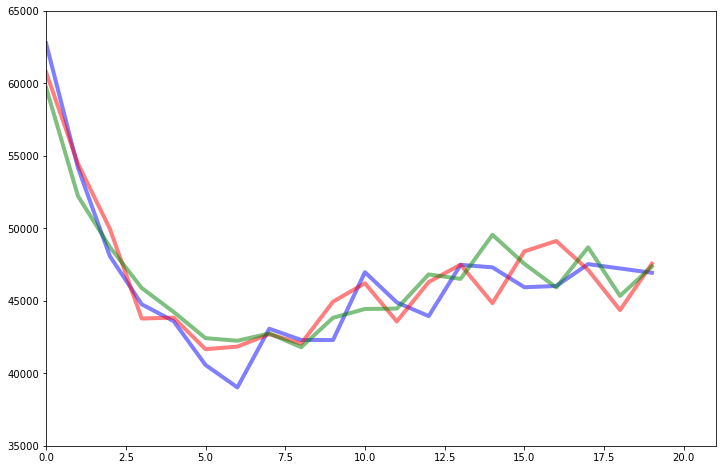

In [37]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(errors, lw=4, color="blue", alpha=0.5)
ax.plot(errors1, lw=4, color="red", alpha=0.5)
ax.plot(errors2, lw=4, color="green", alpha=0.5)
ax.set_xlim(0, 21)
ax.set_ylim(35000, 65000)

In [44]:
bix = LinearRegression()

In [46]:
bix.fit(simple_data, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
bix.coef_

array([  5.40908228e+03,   4.14371252e+15,   3.76668142e+15,
         3.13511647e+03,   9.15121999e+03,  -8.72455173e+02,
         5.88843586e+03,   8.00804294e+03,  -3.92701837e+03,
         1.06585000e+04,   1.78939844e+04,   2.39987500e+03,
         1.39647500e+04,   5.95562500e+02,   1.03308125e+04,
         4.42071875e+03,  -5.26547231e+14,  -9.47785515e+14,
        -1.65481365e+15,  -3.80476414e+15,  -6.41391501e+15,
        -6.17361527e+15,  -5.76182296e+15,  -4.62502465e+15,
        -2.67496131e+15,  -1.45906665e+15,  -4.41565625e+03,
        -6.02852450e+15])